### **Connective Field Modeling: Object-Oriented Programming Version**

Connective Field Modeling is a computational technique used to characterize the relationship between neuronal populations across different regions of the brain. It models how sensory inputs, represented in one visual area, are transformed and projected to another visual area.

---

#### **Connective Field Modeling Parameters**

1. **<span style="color: black;">Sigma</span>**  
   <small>- The spread or size of the connective field.</small>  
   <small>- Represents the spatial extent of influence from the source region.</small>

2. **<span style="color: black;">Eccentricity</span>**  
   <small>- The radial distance of the center of the connective field from the origin of the visual field representation.</small>

3. **<span style="color: black;">Polar Angle</span>**  
   <small>- The angular position of the connective field in visual space.</small>

4. **<span style="color: black;">Variance Explained</span>**  
   <small>- A measure of how well the modeled time series fits the observed data.</small>  
   <small>- Indicates the quality of the connective field fit for each voxel.</small>

5. **<span style="color: black;">Predicted Time Series</span>**  
   <small>- The estimated BOLD signal for each voxel in the target area.</small>  
   <small>- Derived from the best-fit connective field model.</small>

---

#### **Process for Obtaining Connective Field Parameters**

1. **<span style="color: black;">Define Source and Target Areas</span>**  
   <small>- Extract vertices or voxels belonging to these areas.</small>  
   <small>- Use label files or predefined masks to identify regions of interest.</small>

2. **<span style="color: black;">Compute Geodesic Distances</span>**  
   <small>- Compute the true distances on the cortical surface between the vertices in the source area.</small>  

3. **<span style="color: black;">Random Initialization</span>**  
   <small>- Choose an initial random vertex from the source area as a starting point for the connective field center. </small>
   <small>-Set initial parameters to random or default values.</small>

4. **<span style="color: black;">Iterative Optimization</span>**  
   <small>- For each voxel in the target area define a Gaussian function centered at the current connective filed locatin in the source area. </small>
   <small>- Predict the BOLD signal for the target voxel by combining the source time series with the spatial weighting function. </small>
   <small>- Adjust parameters to maximize the fit using a least-squares or gradient-based optimization. </small>

5. **<span style="color: black;">Evaluate Model Fit</span>**  
   <small>- Calculate the variance explained (R²) for the modeled time series compared to the observed time series.</small>  
   <small>- Keep the parameters that provide the best fit for each voxel.</small> 


In [119]:
# Export the required libraries 
import os
import pandas as pd
import random 
import cortex
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [120]:
'''    09/12/2024 TO DO LIST DECEMBER
    
    1. Select a Vertex in the Target area: Choose a vertex from the set V3.
    2. Vertices in the Source area: Examine all vertices within the set V1 in the distance matrix.
    3. Define Range of Sizes: 
        a) Specify a range of radii, e.g., from 0.2 to 5. 
        b)  Set the grid size, e.g., 5 units.
    4. Calculate the Gaussian Weight Function:  
        a) For each distance between the selected vertex in V3 and vertices in V1, calculate a Gaussian weight.
        b) Based on the distance, assign a corresponding weight using the Gaussian function.
    6. Compute the prediction.
    7. Error Evaluation: Calculate the minimum squared error between the observed time course and the prediction.
    8. Iteration: 
        a) Repeat the calculation with new sizes.
        b) Compare the resulting error: If the new size results in a lower error, update it as the optimal size. Otherwise, discard the new size.'''

'''    09/01/2024 TO DO LIST JANUARY 
    1. Iterate Over Source Voxels in V1: for each target voxel, loop through all source voxels in V1. For each source voxel, compute the Gaussian weights.
    2. Optimize Sigma for Each Target-Source Pair: optimize the sigma parameter to maximize the variance explained for the current target-source pair.
    3. Track the Best Fit: store the source voxel and sigma value that gives the highest variance explained for the current target voxel.
    4. Store Results: save the results for the current target voxel in V3 with best source voxel index, best sigma., variance explained., predicted time course.
    5. Repeat for All Target Voxels: repeat the above steps for all voxels in V3.'''

'    09/01/2024 TO DO LIST JANUARY \n    1. Iterate Over Source Voxels in V1: for each target voxel, loop through all source voxels in V1. For each source voxel, compute the Gaussian weights.\n    2. Optimize Sigma for Each Target-Source Pair: optimize the sigma parameter to maximize the variance explained for the current target-source pair.\n    3. Track the Best Fit: store the source voxel and sigma value that gives the highest variance explained for the current target voxel.\n    4. Store Results: save the results for the current target voxel in V3 with best source voxel index, best sigma., variance explained., predicted time course.\n    5. Repeat for All Target Voxels: repeat the above steps for all voxels in V3.'

In [121]:
class Vertex:
    """ The Vertex class is designed to represent a single vertex from a label file generated by FreeSurfer. 
    It stores details about the vertex such as:
    --- Index: A unique identifier for the vertex.
    --- Coordinates: The 3D spatial location (x, y, z) of the vertex.
    --- Visual Area: The functional area of the brain to which the vertex belongs.
    Additionally, the class provides a static method, load_vertices, which reads a label file and creates a 
    list of Vertex objects for a specified visual area, with an option to load only one vertex.""" 
        
    def __init__(self, index: int, x: float, y: float, z: float, visual_area: int):
        self.index = index                   # e.g. 14017 
        self.x = x                           # e.g. -10.072  
        self.y = y                           # e.g. -78.545
        self.z = z                           # e.g. 66.078 
        self.visual_area = visual_area       # e.g. 1

    def load_vertices(labels_path: str, visual_area: int, load_one=False):
        """
        Load vertices from the label file for a given visual area.
            Inputs: 
            --- Label: the path to the label file to load the vertices from.
            --- Visual Area: 1 for source area, 2 for target area
            --- Load One: if true, load only one vertex.
            Outputs:
            --- Vertex: a list of vertices objects loaded from the label file.
        """
        df = pd.read_csv(labels_path, header=None, skiprows=2, delim_whitespace=True)
        df_filtered = df[df[4] == visual_area]

        vertices = np.array([Vertex(*i) for i in df_filtered.itertuples(index=False)])
        if load_one:
            vertex = vertices[0]
            print(f"Loaded one Vertex: Index = {vertex.index}, X = {vertex.x}, Y = {vertex.y}, Z = {vertex.z}, Visual Area = {vertex.visual_area}")
            return [vertex]
            
        # Print how many vertices were loaded for the specific visual area
        print(f"Loaded {len(vertices)} vertices from Visual Area {visual_area} from {labels_path}.")
        
        return vertices

In [122]:
def surfs(subject: str, hemi:str):
    """
    Load the cortical surface for a given subject and hemisphere.
    Returns the cortical surface object for the specified hemisphere.
    """
    if hemi == "lh":
        surf_data = cortex.db.get_surf(subject, "fiducial")[0]  # Left hemisphere
    elif hemi == "rh":
        surf_data = cortex.db.get_surf(subject, "fiducial")[1]  # Right hemisphere
        
    surface = cortex.polyutils.Surface(*surf_data)
    return surface

In [123]:
class Distances(Vertex):
    """ 
    The Distances class computes the geodesic distance matrix for a set of vertices,
    saving it as a CSV file for later use, and provides basic inspection of the results.
    """

    def __init__(self, subject, hemi, matrix_dir, csv_path):
        self.subject = subject
        self.hemi = hemi
        self.matrix_dir = matrix_dir
        self.csv_path = csv_path

    def geodesic_dists(self, hemi, subject, vertices, source, output_dir):
        """
        Compute geodesic distances between source vertices and save the result to a CSV file.
        """
        # Extract source vertex indices
        source_verts = np.array([v.index for v in vertices])

        # Determine the output file path based on hemisphere and source
        output_path = f"{output_dir}/distance_{hemi}_{source}.csv"
        
        # Check if the distance matrix already exists
        if os.path.exists(output_path):
            distance_matrix = pd.read_csv(output_path, index_col=0).values
            print(f"Loaded distance matrix with shape: {distance_matrix.shape}")
            print(f"First 4 rows and columns:\n{distance_matrix[:4, :4]}")
            return distance_matrix
        
        # Load the cortical surface for the given hemisphere
        surface = surfs(subject, hemi)
        
        # Initialize the distance matrix
        dists_source = np.zeros((len(source_verts), len(source_verts)), dtype=np.float32)
    
        # Compute geodesic distances for each source vertex
        for i in range(len(source_verts)):
            dists = surface.geodesic_distance(source_verts[i] - len(vertices))
            for j in range(len(source_verts)):
                dists_source[i, j] = dists[source_verts[j] - len(vertices)]
        
        # Convert the distance matrix to a DataFrame for saving as CSV
        distance_df = pd.DataFrame(dists_source, index=source_verts, columns=source_verts)
        distance_df.to_csv(output_path)
        
        # Print shape and first 4 rows and columns for verification
        print(f"Distance matrix saved with shape: {distance_df.shape}")
        print("First 4 rows and columns:")
        print(distance_df.iloc[:4, :4])
        
        # Return the computed distance matrix
        return dists_source

In [124]:
class TimeCourse:
    """ 
    Loading, processing, and analyzing time course data for single or multiple vertices.
    """

    def __init__(self, time_course_file: str, vertices: list[Vertex], cutoff_volumes: int):
        self.vertices = vertices  # List of Vertex objects
        self.cutoff_volumes = cutoff_volumes
        self.data = np.load(time_course_file)  # Load time course data
        self.tSeries = self.load_time_courses()

    def load_time_courses(self) -> dict:
        duration = self.data.shape[0]
        tSeries = {}
        for vertex in self.vertices:
            index = vertex.index
            time_course = self.data[self.cutoff_volumes:duration, index]
            tSeries[index] = time_course

        # Print details about the tSeries dictionary
        return tSeries

    def z_score(self) -> dict:
        z_scored_data = {}
        for index, time_course in self.tSeries.items():
            z_scored_data[index] = (time_course - np.mean(time_course)) / np.std(time_course)
        return z_scored_data

    def plot_time_series(self, vertex_index: int, show: bool = True) -> None:
        if vertex_index not in self.tSeries:
            print(f"Vertex {vertex_index} not found in the time series data.")
            return

        time_course = self.tSeries[vertex_index]
        plt.figure(figsize=(10, 5))
        plt.plot(time_course, label=f'Vertex Index: {vertex_index}', color='blue')
        plt.title(f'Time Series for Vertex {vertex_index}')
        plt.xlabel('Time (Volumes) after Cutoff')
        plt.ylabel('BOLD Signal')
        plt.legend()
        plt.grid()
        if show:
            plt.show()
        
    def plot_comparison(self, z_scored_data: dict, vertex_index: int, title_prefix: str, show: bool = True) -> None:
        """
        Plot the original and z-scored time series for a specific vertex.

        Args:
            z_scored_data (dict): Z-scored time series data.
            vertex_index (int): Vertex index to plot.
            title_prefix (str): Prefix for the plot title (e.g., 'Target' or 'Source').
            show (bool): Whether to display the plot immediately.
        """
        original_time_course = self.tSeries[vertex_index]
        z_scored_time_course = z_scored_data[vertex_index]
        plt.figure(figsize=(12, 6))
        plt.plot(original_time_course, label="Original Time Series", linestyle="-", marker="o", alpha=0.7)
        plt.plot(z_scored_time_course, label="Z-Scored Time Series", linestyle="--", marker="x", alpha=0.7)
        plt.title(f"{title_prefix} Vertex {vertex_index} - Before and After Z-Scoring")
        plt.xlabel("Time Points")
        plt.ylabel("BOLD Signal")
        plt.legend()
        plt.grid()
        if show:
            plt.show()

In [125]:
class ConnectiveField:
    """Connective Field class to calculate sigma, eccentricity, variance explained, polar angle, and predicted time course for a voxel."""

    def __init__(self, center_vertex: Vertex, vertex: Vertex):
        """
        Initialize the ConnectiveField class with a specific vertex.
        """
        self.vertex = vertex  # Use the vertex passed during initialization
        self.center_vertex = center_vertex  # Center of the Gaussian
        self.sigma = None  # Spread of the connective field
        self.eccentricity = None  # Distance from center (eccentricity)
        self.polar_angle = None  # Angle to indicate direction
        self.variance_explained = None  # Fit metric for model evaluation
        self.predicted_time_course = None  # Predicted BOLD signal time series
        self.observed_time_series = None  # Observed time series for the voxel
        self.best_fit = None  # Stores best optimization fit

    # Select a Vertex in the Target Area
    def select_target_vertex(self, idxTarget: list[Vertex]) -> Vertex:
        selected_vertex = random.choice(idxTarget)
        print(f"Selected Target Vertex: Index = {selected_vertex.index}, Coordinates = ({selected_vertex.x}, {selected_vertex.y}, {selected_vertex.z})")
        return selected_vertex

    # Define Range of Sizes
    def define_size_range(self, start: float = 0.2, stop: float = 5.0, num: int = 10) -> list:
        sigma_values = np.linspace(start, stop, num).tolist()
        print(f"Sigma Values for Optimization: {sigma_values}")
        return sigma_values

    # Define the Gaussian distribution
    def calculate_gaussian_weights(self, distances: np.ndarray, sigma: float) -> np.ndarray:
        """
        A Gaussian weight is computed for each source vertex based on its distance from the center vertex and the current sigma value.
        The Gaussian weights determine how much influence each source vertex has on the predicted time series.
        The closer a vertex is to the center, the higher its weight 
        """
        weights = np.exp(-np.square(distances) / (2 * sigma ** 2))  # Compute Gaussian weights
        weights_normalized = weights / np.sum(weights)  # Normalize the weights
        return weights_normalized

    # Compute the Prediction
    def compute_prediction(self, source_time_series: dict, distances: np.ndarray, sigma: float) -> np.ndarray:
        weights = self.calculate_gaussian_weights(distances, sigma) # Calculate Gaussian weights
        time_points = len(next(iter(source_time_series.values()))) # Initialize predicted time series as zeros # CHATGPT. 
        predicted_time_series = np.zeros(time_points)

        # Each source vertex’s time series is scaled (multiplied) by its corresponding Gaussian weight, 
        # and the results are summed to form the predicted time series for the target vertex. # HELP. Why are they summed? I don't understand. 
        # I think the code will iterate overa all each source vertex’s time series within the Gaussian weight to find the best one, am I wrong?
        # Please check the documentations for me :)
        for i, (vertex_index, time_series) in enumerate(source_time_series.items()):
            predicted_time_series += weights[i] * time_series

        return predicted_time_series

    # Error Evaluation
    def evaluate_fit(self, observed: np.ndarray, predicted: np.ndarray) -> float:
        """
        Evaluate the variance explained (R²) between observed and predicted time series.
        """
        ss_total = np.sum((observed - np.mean(observed)) ** 2) # The total variance in the observed time series.
        ss_residual = np.sum((observed - predicted) ** 2) # The variance in the observed time series that isn’t explained by the predicted time series. 
        variance_explained = 1 - (ss_residual / ss_total) # The proportion of variance explained by the prediction.
        return variance_explained

    # Iteration for Optimization
    def optimize_parameters(self, observed: np.ndarray, source_time_series: dict, distances: np.ndarray, sigma_values: list):
        best_sigma = None 
        best_variance_explained = -np.inf 
        best_prediction = None # The predicted time series that corresponds to the best fit.

        for sigma in sigma_values: # Iterates through each value of sigma to calculate how well the predicted time series matches the observed time series
            predicted = self.compute_prediction(source_time_series, distances, sigma) # Compute the predicted time series for the current sigma

            # Evaluate the model fit
            variance_explained = self.evaluate_fit(observed, predicted)

            # Update the best fit if variance explained improves
            if variance_explained > best_variance_explained:
                best_variance_explained = variance_explained # Stores the best R² value.
                best_sigma = sigma # Stores the sigma value that provided the best fit so far.
                best_prediction = predicted # Stores the predicted time series corresponding to best_sigma

        # Store the best results
        self.sigma = best_sigma
        self.variance_explained = best_variance_explained
        self.predicted_time_course = best_prediction

        print(f"Best Sigma: {best_sigma}, Variance Explained: {best_variance_explained:.4f}")

    # Plot Observed vs Predicted Time Series
    def plot_time_series(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.observed_time_series, label='Observed Time Series', linestyle='-', marker='o')
        plt.plot(self.predicted_time_course, label='Predicted Time Series', linestyle='--', marker='x')
        plt.title('Observed vs Predicted Time Series')
        plt.xlabel('Time Points')
        plt.ylabel('BOLD Signal')
        plt.legend()
        plt.grid(True)
        plt.show()

### The Main Script

Loaded 1031 vertices from Visual Area 3 from D:\Documents\School\EGRET-AAA\CFM\data/freesurfer/sub-34/label/lh.manualdelin.label.
Loaded 1394 vertices from Visual Area 1 from D:\Documents\School\EGRET-AAA\CFM\data/freesurfer/sub-34/label/lh.manualdelin.label.
Loaded distance matrix with shape: (1394, 1394)
First 4 rows and columns:
[[ 0.          0.84379625 16.676992   16.238483  ]
 [ 0.8309592   0.         16.922224   16.454084  ]
 [16.660679   16.897541    0.          1.0473223 ]
 [16.244816   16.449427    0.99186224  0.        ]]


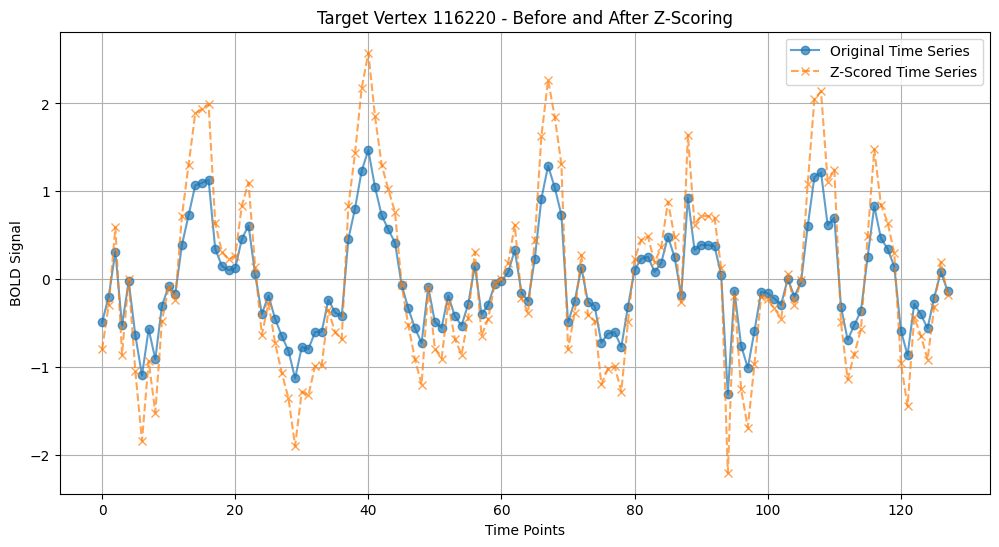

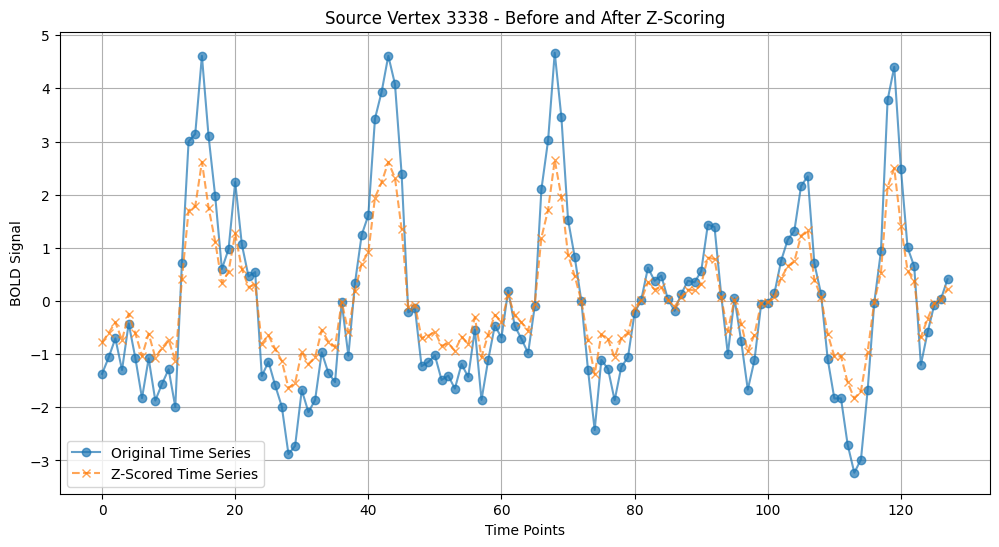

Fixed Target Vertex: Index = 116220, Coordinates = (-17.714, -73.515, 7.987)
Center Vertex in V1: Index = 2089, Coordinates = (-10.691, -87.211, 9.925)
Index Map: {3338: 0, 3337: 1, 2898: 2, 2899: 3, 3329: 4, 3775: 5, 4249: 6, 3785: 7, 112377: 8, 103517: 9, 4264: 10, 3795: 11, 3794: 12, 117724: 13, 3345: 14, 4263: 15, 4257: 16, 4236: 17, 4725: 18, 4731: 19, 4739: 20, 4262: 21, 4719: 22, 5300: 23, 5324: 24, 104379: 25, 5311: 26, 4738: 27, 5299: 28, 98982: 29, 5310: 30, 5897: 31, 5323: 32, 4730: 33, 5878: 34, 5877: 35, 5896: 36, 97019: 37, 5291: 38, 3768: 39, 3320: 40, 3321: 41, 3355: 42, 4703: 43, 4718: 44, 112201: 45, 5915: 46, 5895: 47, 6524: 48, 6523: 49, 5894: 50, 5914: 51, 120087: 52, 5913: 53, 114053: 54, 5871: 55, 6506: 56, 6505: 57, 96603: 58, 6487: 59, 6471: 60, 5864: 61, 5322: 62, 4729: 63, 5340: 64, 5321: 65, 5320: 66, 5339: 67, 5912: 68, 5931: 69, 5338: 70, 4737: 71, 4261: 72, 4260: 73, 4736: 74, 4735: 75, 4749: 76, 4748: 77, 5353: 78, 4235: 79, 4234: 80, 4717: 81, 4233: 82,

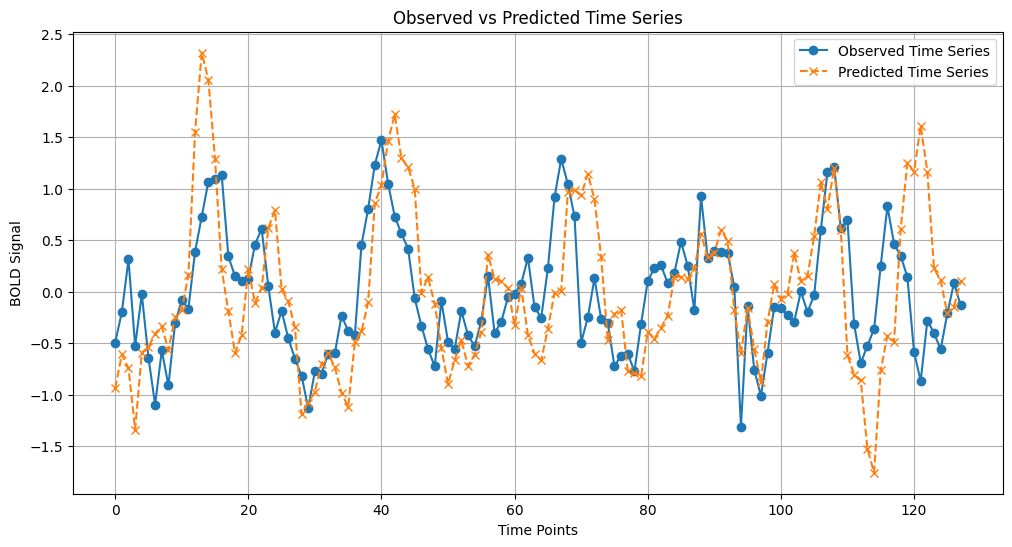

In [126]:
if __name__ == "__main__":
    # Paths for Federica
    MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA\derivatives'
    CODE_PATH = '/Volumes/FedericaCardillo/cflaminar_drafting/bayesianCF/egretaaa/OBJ_MCMC_CF'
    
    # Paths for Lloyd
    #MAIN_PATH = r"D:\Documents\School\EGRET-AAA\CFM\data" 
    #CODE_PATH = r"C:\Users\lloyd\Documents\School\EGRET-AAA\Repos\OBJ_MCMC_CF\OBJ_MCMC_CF"
    
    subj = 'sub-34'
    ses = 'ses-02'
    hemi = 'lh'
    delineation = 'manualdelin'
    denoising = 'nordic'
    cutoff_volumes = 8
    target_visual_area = 3
    source_visual_area = 1
    load_one = None  # Set to True if you want to load just one vertex, False to load them all
    
    labels_path = f"{MAIN_PATH}/freesurfer/{subj}/label/{hemi}.{delineation}.label"
    time_series_path = f"{MAIN_PATH}/pRFM/{subj}/{ses}/{denoising}/{subj}_{ses}_task-RET_hemi-LR_desc-avg_bold_GM.npy"
    output_dir = f"{CODE_PATH}"
    distance_matrix_path = f"{CODE_PATH}/distance_{hemi}_{source_visual_area}.csv"

    # 1. Load Source and Target Vertices
    idxTarget = Vertex.load_vertices(labels_path, target_visual_area, load_one)
    idxSource = Vertex.load_vertices(labels_path, source_visual_area, load_one)

    # 2. Load the Distance Matrix
    distances_class = Distances(subject=subj, hemi=hemi, matrix_dir=CODE_PATH, csv_path=distance_matrix_path)
    distance_matrix = distances_class.geodesic_dists(hemi=hemi, subject=subj, vertices=idxSource, source=source_visual_area, output_dir=CODE_PATH)

    # 3. Load Time Series Data
    target_time_course = TimeCourse(time_course_file=time_series_path, vertices=idxTarget, cutoff_volumes=cutoff_volumes)
    source_time_course = TimeCourse(time_course_file=time_series_path, vertices=idxSource, cutoff_volumes=cutoff_volumes)

    # Z-Score Time Series
    z_scored_target = target_time_course.z_score() 
    z_scored_source = source_time_course.z_score()
    target_time_course.plot_comparison(z_scored_data = z_scored_target, vertex_index = idxTarget[0].index, title_prefix = "Target") # Plot the comparison for the same vertex (original vs. z-scored)
    source_time_course.plot_comparison(z_scored_data = z_scored_source, vertex_index = idxSource[0].index, title_prefix = "Source") # Plot the comparison for the same vertex (original vs. z-scored)
    
    # 4. Select a Fixed Target Vertex (V3) and a Random Center Vertex (V1)
    target_vertex = idxTarget[0]  # Select the first vertex in V3
    print(f"Fixed Target Vertex: Index = {target_vertex.index}, Coordinates = ({target_vertex.x}, {target_vertex.y}, {target_vertex.z})")
    # center_vertex = idxSource[10]
    center_vertex = random.choice(idxSource)  # Randomly select a vertex in V1 as the center
    print(f"Center Vertex in V1: Index = {center_vertex.index}, Coordinates = ({center_vertex.x}, {center_vertex.y}, {center_vertex.z})")

    # 5. Create the ConnectiveField Class
    connective_field = ConnectiveField(center_vertex=center_vertex, vertex=target_vertex)

    # 6. Extract Distances and Time Series
    index_map = {vertex.index: i for i, vertex in enumerate(idxSource)}
    print(f"Index Map: {index_map}")
    # Extracts the distances from the center vertex in V1 to all other vertices in V1 using the distance matrix
    distances = np.array([distance_matrix[index_map[center_vertex.index], index_map[v.index]] for v in idxSource])  ### What is this? Can I visualize it (plot or print)?  
    # Compute statistics for the distances array
    max_distance = np.max(distances)
    min_distance = np.min(distances)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    std_distance = np.std(distances)
    total_values = distances.size
    print(f"Maximum Distance: {max_distance}")
    print(f"Minimum Distance: {min_distance}")
    print(f"Mean Distance: {mean_distance}")
    print(f"Median Distance: {median_distance}")
    print(f"Standard Deviation of Distances: {std_distance}")
    print(f"Total Number of Values: {total_values}")
    # Dictionary where the keys are the vertex indices and the values are their corresponding time series arrays.
    source_time_series = {v.index: source_time_course.tSeries[v.index] for v in idxSource} ### What is this? Can I visualize it (plot or print)? 
    # Extracts the time series for the target vertex in V3 (target area).
    observed = target_time_course.tSeries[target_vertex.index]  ### What is this? Can I visualize it (plot or print)? 

    # 7. Define Sigma Range for Optimization
    sigma_values = connective_field.define_size_range(start=0.2, stop=5.0, num=10) 

    # 8. Run Optimization
    connective_field.optimize_parameters(observed = observed, source_time_series = source_time_series, distances = distances, sigma_values = sigma_values)

    # 9. Print Optimized Results
    print(f"Optimized Sigma: {connective_field.sigma}")

    # 10. Plot the Observed vs. Predicted Time Series
    connective_field.observed_time_series = observed
    connective_field.plot_time_series()